In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

# Helper functions

These are borrowed from the `Convert.ipynb` file.

In [2]:
headings = ['Building Identifier',
            'Country',
             'City',
             'Quality / Stage of Data',
             'Construction Date',
             'Building Type',
             'Gross Floor Area']

In [3]:
df = pd.read_excel('../Dataset/dataset.xlsx',header=1).drop('Unnamed: 0',axis=1)

In [4]:
df

,Building Identifier,Country,City,Quality / Stage of Data,Construction Date,Building Type,Gross Floor Area,000_G2010.20.000_03 00 00.00_kg_1,000_B1010.20.000_03 00 00.00_kg_1,000_C1010.10.000_04 22 00.00_kg_1,...,000_B2010.10.000_07 46 16.00_kg_2,001_B2010.80.000_07 27 00.00_kg_2,001_B2010.80.000_07 21 13.00_kg_2,001_B2010.10.000_09 24 23.00_kg_2,0B1_A5020.10.000_06 11 00.00_kg_2,0B1_A5020.10.000_06 11 00.00_kg_1,0B1_A5020.10.000_09 21 16.00_kg_1,000_C1010.10.000_07 21 13.00_kg_1,00R_B3010.90.000_07 21 13.00_kg_1,00R_B1020.20.000_07 51 13.00_kg_1
0,1,CA,TOR,00IFC,2021,SND,521.18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,CA,TOR,00IFC,2021,SND,389.24,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,CA,TOR,00IFC,2021,SND,411.64,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,CA,TOR,00IFC,2021,SND,269.56,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,CA,TOR,00IFC,2011,OFF,11248.00,13704.0,1.776816e+06,19397.560000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,CA,TOR,00IFC,2011,APB,11317.00,NaN,1.514400e+06,53877.650000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,CA,TOR,00IFC,2021,SND,445.99,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,CA,TOR,00IFC,2021,SND,438.45,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,CA,TOR,00IFC,2021,SND,714.07,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,CA,TOR,00IFC,2021,SND,343.24,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
mapper = pd.read_excel('../Conversion/Mapping material names_20210324.xlsx',header=2,usecols='B:U').replace(r'\n','', regex=True) 

In [6]:
name_conversion = pd.read_csv('name_conversion.csv')
building_name_conversion = pd.read_csv('building_type_name_conversion.csv')

In [7]:
building_name_map = {k['Building Code']:k['Building Type'] for _,k in building_name_conversion.iterrows()}

In [8]:
name_map = {k.Code:k.Category for _,k in name_conversion.iterrows()}

In [9]:
additional_categories_map = {v:k for k,v in {
    'Continuous Footings':'0CF',
    'Foundation Walls':'0FW',
    'Spread Footings':'0SF',
    'Column Piers':'0CP',
    'Columns Supporting Floors':'CSF',
    'Floor Girders and Beams':'FGB',
    'Floor Trusses':'0FT',
    'Floor Joists':'0FJ',
    'Columns Supporting Roofs':'CSR',
    'Roof Girders and Beams':'RGB',
    'Roof Trusses':'0RT',
    'Roof Joists':'0RJ',
    'Parking Bumpers':'0PB',
    'Precast Concrete Stair Treads':'PCS',
    'Roof Curbs':'0RC',
    'Exterior Wall Construction':'EWC',
    'Composite Decking':'CPD',
    'Cast-in-Place concrete':'CIC',
    'Floor Structural Frame':'FSF',
    'Associated Metal Fabrications':'AMF',
    'Floor Construction Supplementary Components':'FCS',
    'Roof Construction Supplementary Components':'RCS',
    'Residential Elevators':'0RE',
    'Vegetated Low-Slope Roofing':'VLR',
    'Swimming Pools':'SWP',
    'Excavation Soil Anchors':'ESA',
    'Floor Trusses':'FTS',
    'Roof Window and Skylight Performance':'RWS'}.items()
}

additional_categories_map['0FT'] = 'Floor Trusses'

In [10]:
def get_material_name(l):
    try:
        split = re.split('[_\.\ ]',l) #Split up the code into its requisite parts
        result = mapper[mapper['Unnamed: 7'] == split[1]+'.'+split[2]] #Filter by Level 4 Master Format
        if len(result) == 0:
            result = mapper #If that code does not exist in the table, reset
        if len(result) == 1:
            return result['Mapping Table'].values[0] #If it maps to exactly one value, return that. We do this check after every step
        if split[3] != '000': #Check if there is an additional code, and if so filter by that
            result = result[result['Level 5\n'] == additional_categories_map[split[3]]]
            if len(result) == 1:
                return result['Mapping Table'].values[0]

        #Now filter by UniFormat.
        #Filter only by the level of UniFormat present. If the code is XX 00 00, for example, then we only have Level 1.
        if int(split[5]) == 0: 
            result = result[result['Unnamed: 12'] == f'{split[4]} 00 00']
            if len(result) == 1:
                return result['Mapping Table'].values[0]
        elif int(split[6]) == 0:
            result = result[(result['Unnamed: 14'] == f'{split[4]} {split[5]} 00') | (result['Unnamed: 16'] == f'{split[4]} {split[5]} 00')]
            if len(result) == 1:
                return result['Mapping Table'].values[0]
        else:
            result = result[result['Unnamed: 18'] == f'{split[4]} {split[5]} {split[6]}']
            if len(result) == 1:
                return result['Mapping Table'].values[0]

        #If we couldn't find it, or there is an unspecified edge case, return None. 
        if len(result) == 0:
            return None

        #If there are multiple results but they all map to the same material, return that material.
        if all(element == result['Mapping Table'].values[0] for element in result['Mapping Table'].values):
            return result['Mapping Table'].values[0]
        else:
            return None
    except:
        return None

# 1. Plot sample figures

Here we plot building material mass, and volume histograms.

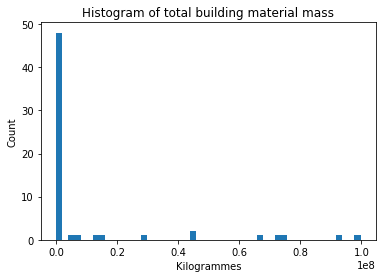

In [11]:
plt.hist(df[[c for c in df.columns if 'kg' in c]].sum(axis=1),bins=50);
plt.title('Histogram of total building material mass')
plt.xlabel('Kilogrammes')
plt.ylabel('Count');

# 2. Investigate a specific material

In this example, we use the helper function `get_material_name()` to select columns which match `steel`. Then, we calculate the average amount of steel used by floor, produce a table of values by Level 3 MasterFormat only, and calculate the average values for these by year in the dataset.

In [12]:
material = 'steel'
cols = []
for column in df.columns[7:]: #Iterate through columns that represent materials
    if get_material_name(column) == 'steel' and 'kg' in column: #If that column represents steel and is a mass value:
        cols.append(column) #Append to cols

In [13]:
steel_df = df[df.columns[1:7].to_list() + cols].fillna(0) #Select only the heading columns and the columns related to steel

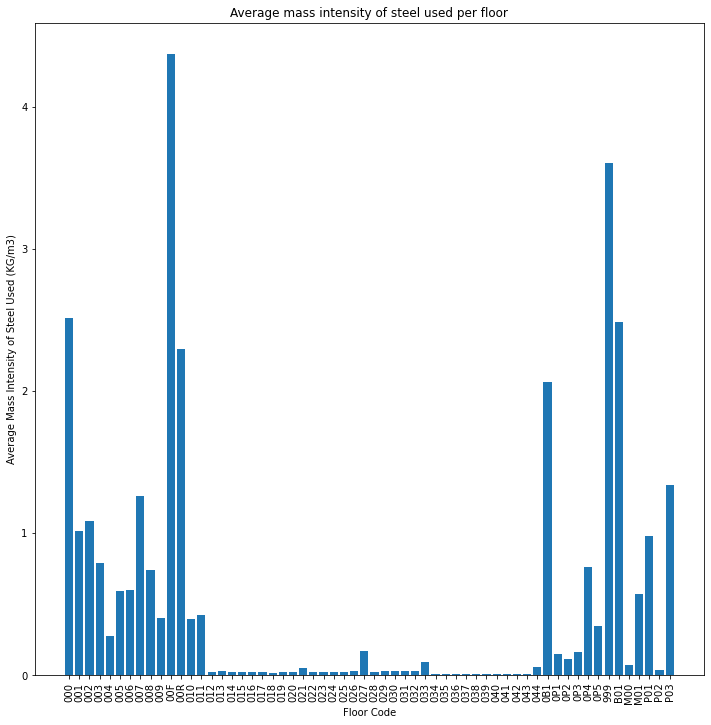

In [14]:
grouping_function = lambda x: x.split('_')[0] #This function takes in a full column name, like "000_G2010.20.000_03 00 00.00_m3_1", and returns only the floor.
to_draw = steel_df[cols].groupby(grouping_function,axis=1).sum().replace(0,np.NaN).div(df['Gross Floor Area'],axis='rows').mean()
plt.figure(figsize=(12,12))
plt.bar(to_draw.keys(), to_draw.values)
plt.xticks(rotation=90)
plt.title('Average mass intensity of steel used per floor')
plt.ylabel('Average Mass Intensity of Steel Used (KG/m3)')
plt.xlabel('Floor Code');

Now, we will aggregate to Level 3 MasterFormat codes, and display these values for the first three entries.

In [15]:
f = lambda x: name_map[re.split('[_\.\ ]',x)[1]] #This function takes in a full column name and returns only the Level 3 MasterFormat code.
steel_general_df = steel_df[cols].groupby(f,axis=1).sum()

In [16]:
steel_general_df.mean().sort_values(ascending=False)

Exterior Walls                77353.438405
Special Foundations           26338.802948
Floor Construction            14318.543691
Stairs                         6580.472545
Standard Slabs-on-Grade        5445.154282
Standard Foundations           5392.813457
Exterior Louvers and Vents     1488.385267
Roof Construction              1317.269238
Interior Specialties            316.689885
Vertical Conveying Systems      253.659106
Site Development                119.830250
Roadways                         86.978000
Exterior Doors and Grilles       75.505465
Structural Slabs-on-Grade        45.919862
Pits and Bases                   29.302840
Building Subdrainage             13.059478
Interior Doors                   11.526000
Roofing                           5.474165
dtype: float64

## Pie chart version A: on-pie chart labels for all > 1%

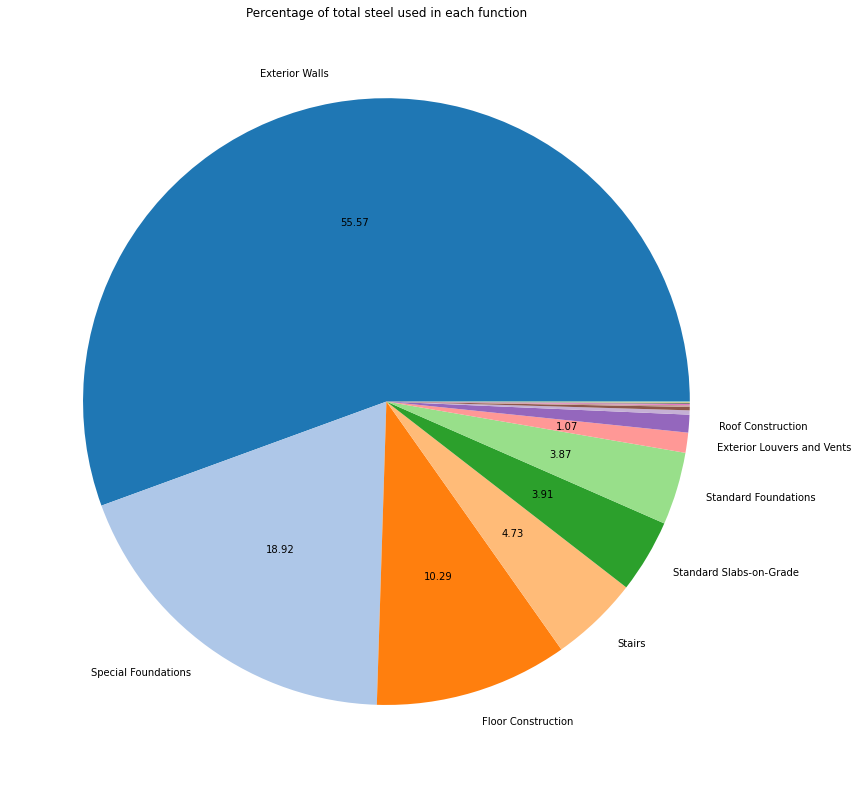

In [17]:
def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1 else ''
to_plot = steel_general_df.mean().sort_values(ascending=False)
to_plot.plot.pie(figsize=(12,12),colormap='tab20',autopct=my_autopct,labels=[k if v > 1000 else '' for k,v in to_plot.items()])
plt.ylabel('')
plt.title('Percentage of total steel used in each function');
# plt.legend(loc='center left',bbox_to_anchor=(-0.20, 0.75));
plt.tight_layout();

## Pie version B: external legend with slice labels

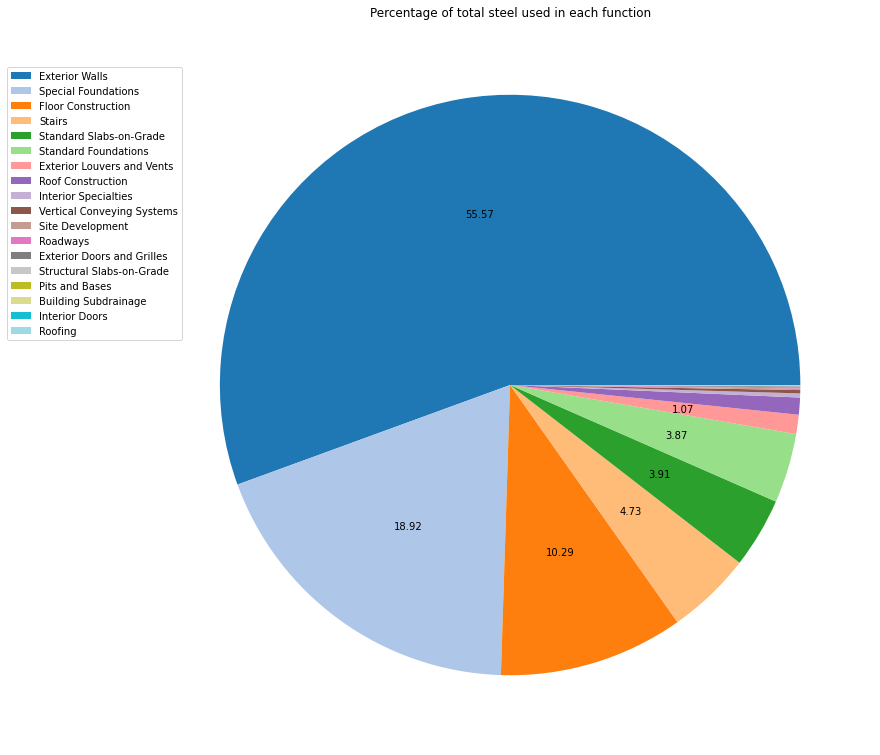

In [18]:
def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1 else ''
to_plot = steel_general_df.mean().sort_values(ascending=False)
to_plot.plot.pie(figsize=(12,12),colormap='tab20',autopct=my_autopct,labeldistance=None)
plt.ylabel('')
plt.title('Percentage of total steel used in each function');
plt.legend(loc='center left',bbox_to_anchor=(-0.20, 0.75));
plt.tight_layout();

We can produce a pie chart for a single building, also.

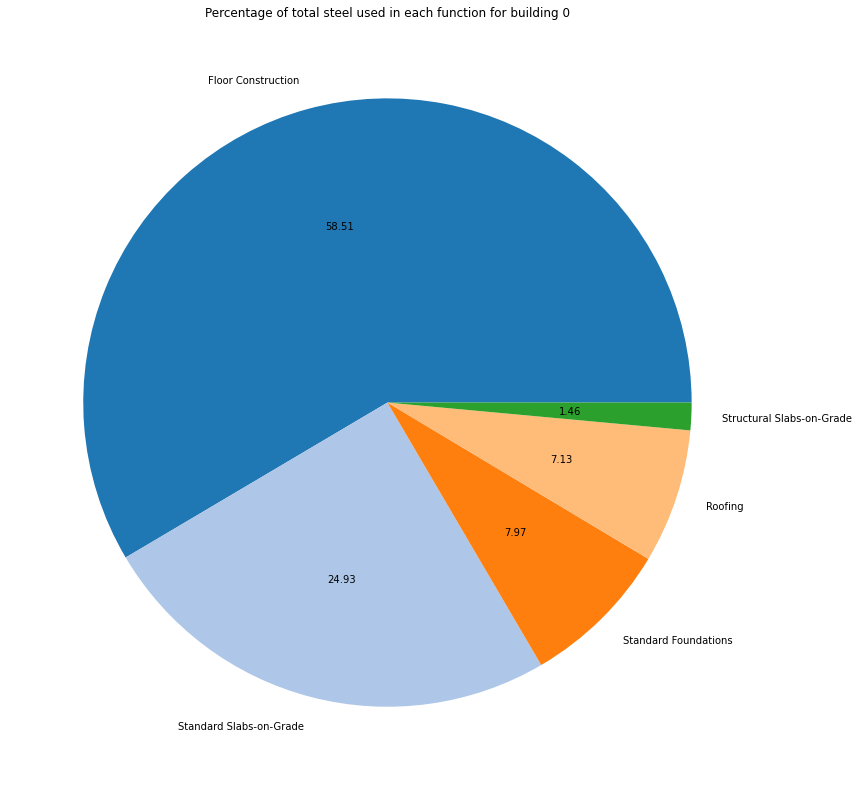

In [19]:
BUILDING_ID = 0

def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1 else ''
to_plot = steel_general_df.loc[BUILDING_ID,:].sort_values(ascending=False)
to_plot.plot.pie(figsize=(12,12),colormap='tab20',autopct=my_autopct)
plt.ylabel('')
plt.title(f'Percentage of total steel used in each function for building {BUILDING_ID}');
plt.tight_layout();



Or an entire class of building:

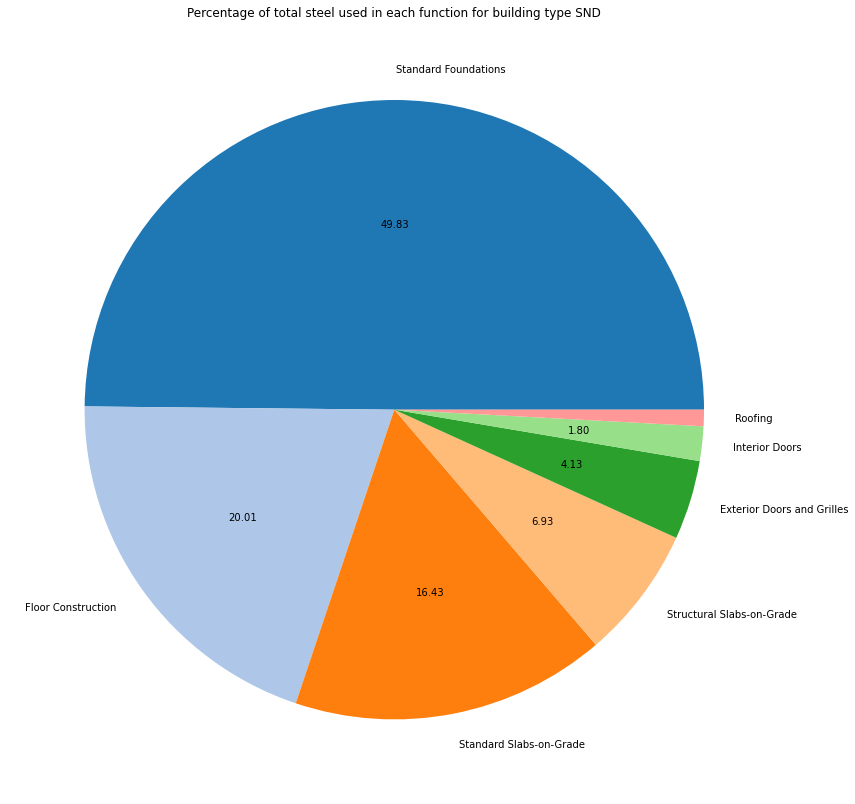

In [20]:
steel_general_df = pd.concat([steel_df['Building Type'],steel_df[cols].groupby(f,axis=1).sum()],axis=1)
BUILDING_TYPE = 'SND'

def my_autopct(pct):
    return ('%.2f' % pct) if pct > 1 else ''
to_plot = steel_general_df[steel_general_df['Building Type'] == BUILDING_TYPE][steel_general_df.columns[1:]].mean().sort_values(ascending=False)
to_plot.plot.pie(figsize=(12,12),colormap='tab20',autopct=my_autopct)
plt.ylabel('')
plt.title(f'Percentage of total steel used in each function for building type {BUILDING_TYPE}');
plt.tight_layout();


We can also calculate the average for each Level 3 MasterFormat code by year of construction:

In [21]:
steel_general_df = pd.concat([steel_df[headings[1:]],steel_df[cols].groupby(f,axis=1).sum()],axis=1)
steel_general_df.groupby('Construction Date').mean()

,Gross Floor Area,Building Subdrainage,Exterior Doors and Grilles,Exterior Louvers and Vents,Exterior Walls,Floor Construction,Interior Doors,Interior Specialties,Pits and Bases,Roadways,Roof Construction,Roofing,Site Development,Special Foundations,Stairs,Standard Foundations,Standard Slabs-on-Grade,Structural Slabs-on-Grade,Vertical Conveying Systems
Construction Date,,,,,,,,,,,,,,,,,,,
1913,161.080000,0.000000,0.000000,0.000,0.000000e+00,0.000000,0.00,0.000000,0.00000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,48.162700,0.000000,0.000000
1917,199.930000,0.000000,0.000000,0.000,0.000000e+00,0.000000,0.00,0.000000,0.00000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.818800,0.000000
1969,373.605000,0.000000,0.000000,0.000,0.000000e+00,0.000000,0.00,0.000000,0.00000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.436400,0.000000
1988,21934.000000,0.000000,0.000000,0.000,5.039204e+03,747.739297,0.00,0.000000,0.00000,0.000,0.000000,0.000000,0.000000,0.000000,5677.162679,67016.749257,24922.610789,0.000000,334.146341
2007,73600.000000,0.000000,0.000000,0.000,1.752312e+06,32828.900000,0.00,16665.000000,0.00000,0.000,2249.000000,0.000000,0.000000,122069.070000,86571.370000,0.000000,68246.330000,0.000000,7925.800000
2009,73083.000000,0.000000,0.000000,88591.000,2.658847e+06,77762.100000,0.00,0.000000,0.00000,3242.050,63740.722253,0.000000,0.000000,0.000000,0.000000,92590.750000,58354.545000,0.000000,6959.600000
2011,11282.500000,0.000000,0.000000,0.000,1.085611e+05,93517.011675,0.00,0.000000,180.15750,988.315,0.000000,0.000000,1698.740000,11019.437500,2180.730000,10048.588750,17521.985000,0.000000,0.000000
2016,30345.000000,0.000000,0.000000,0.000,0.000000e+00,16993.067500,0.00,0.000000,235.10750,0.000,0.000000,0.000000,0.000000,188421.220000,23831.815000,7123.286250,19159.102500,0.000000,0.000000
2017,39392.013333,0.000000,0.000000,0.000,2.267603e+03,151410.914567,0.00,0.000000,309.21346,0.000,2272.634333,0.000000,1264.111667,209661.285467,29604.705000,18289.127707,27702.060870,0.000000,0.000000


We can get the average amount of steel in KG used per building type:

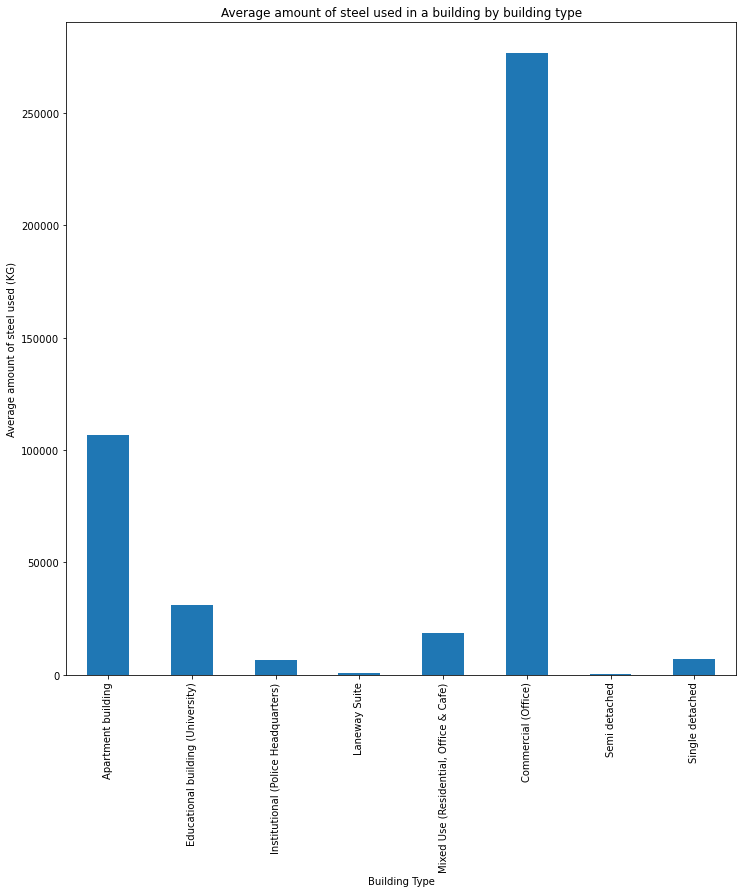

In [22]:
steel_general_df.groupby('Building Type').sum().mean(axis=1).rename(index=building_name_map).plot(kind='bar',figsize=(12,12))
plt.ylabel('Average amount of steel used (KG)')
plt.title('Average amount of steel used in a building by building type');

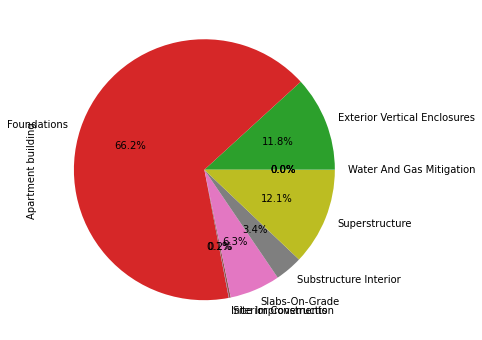

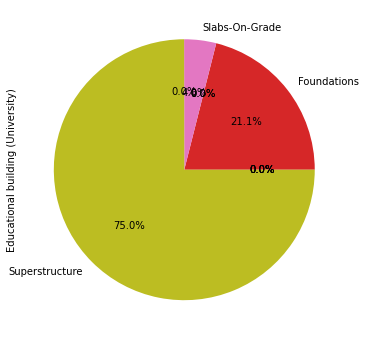

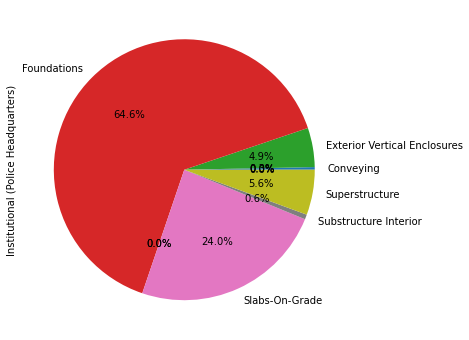

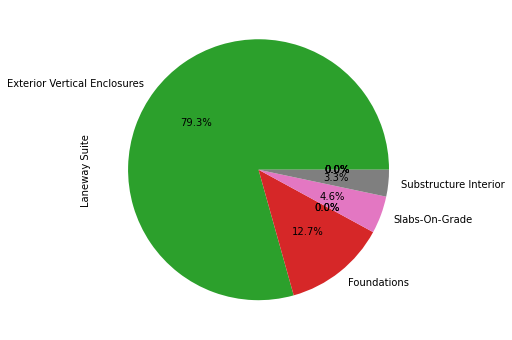

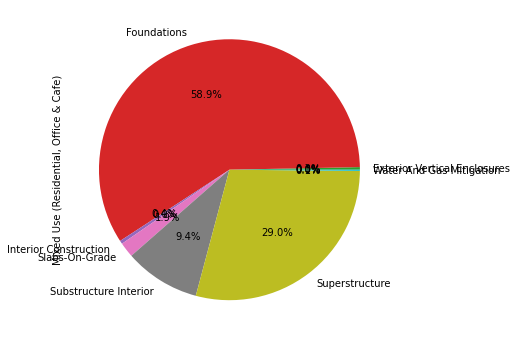

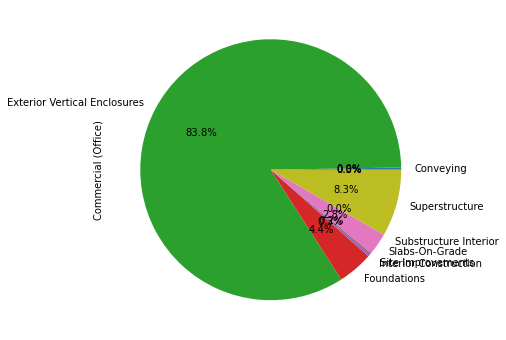

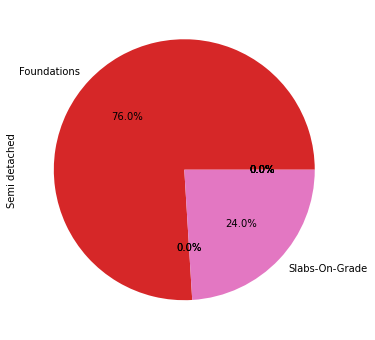

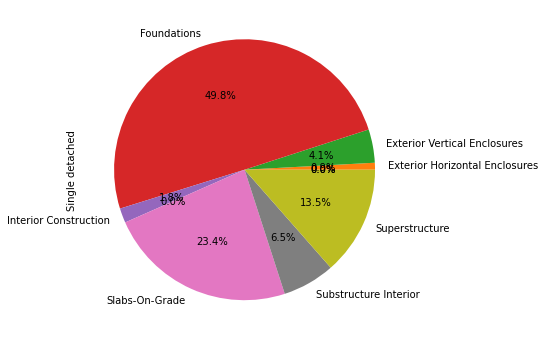

In [23]:
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0:3]] #From a full code, return only the use code and uncertainty code.
tdf = pd.concat([df['Building Type'],df[cols].groupby(f,axis=1).sum()],axis=1).groupby('Building Type').mean().rename(index=building_name_map).transpose()
for i,k in enumerate(tdf.columns.values):
    tdf.plot.pie(y=k,figsize=(6,6),autopct='%1.1f%%',legend=False);

# 3. Uncertainty by Building Type

In this section, we look at the uncertainty code associated with each column. We collect these by building type and then report the number of each value per type of building.

In [24]:
uncertainty_level = {} 
for k,v in df.iterrows():
    #Initialise empty lists for each building type as they occur
    if v['Building Type'] not in uncertainty_level.keys():
        uncertainty_level[v['Building Type']] = []
    #Append the uncertainty value for each column that is non-NaN
    for key in v[~v.isna()].keys()[7:]:
        uncertainty_level[v['Building Type']].append(key.split('_')[-1])

In [25]:
from collections import Counter

In [26]:
for k,v in uncertainty_level.items():
    uncertainty_level[k] = Counter(v) #Construct a Counter object per building type

In [27]:
uncertainty_level

{'SND': Counter({'1': 1720, '2': 711, '4': 349}),
 'OFF': Counter({'1': 494, '3': 307}),
 'APB': Counter({'1': 1171, '2': 1, '3': 971}),
 'SMD': Counter({'1': 191, '2': 61, '4': 27}),
 'EDU': Counter({'1': 93, '3': 24, '2': 6}),
 'INS': Counter({'1': 90, '3': 77, '2': 1}),
 'MIX': Counter({'1': 363, '3': 276}),
 'LNW': Counter({'2': 46, '1': 142, '4': 19})}

Next, we aggregate columns by use code and uncertainty combined, and report the average by building type.

In [28]:
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0]] + '/' + x.split('_')[-1].split('.')[0] #From a full code, return only the use code and uncertainty code.
by_function_df = pd.concat([df[headings[1:]],df[cols].groupby(f,axis=1).sum()],axis=1)

In [29]:
by_function_df.groupby('Building Type').mean().rename(index=building_name_map)

,Construction Date,Gross Floor Area,Interiors/1,Interiors/2,Services/1,Shell/1,Shell/2,Shell/3,Shell/4,Sitework/1,Sitework/3,Substructure/1,Substructure/2,Substructure/3,Substructure/4
Building Type,,,,,,,,,,,,,,,
Apartment building,2015.80,45505.412000,192.108455,0.000,0.000000,4.767977e+04,0.0000,42919.090000,0.000000,225.295,533.172000,192895.616600,0.000000,95502.505000,0.000000
Educational building (University),2016.50,7901.000000,0.000000,0.000,0.000000,2.214476e+05,0.0000,3218.892500,0.000000,0.000,0.000000,0.000000,0.000000,74976.547506,0.000000
Institutional (Police Headquarters),1988.00,21934.000000,0.000000,0.000,334.146341,1.297866e+02,0.0000,10716.366983,0.000000,0.000,0.000000,0.000000,0.000000,92557.312757,0.000000
Laneway Suite,2020.00,150.010000,0.000000,0.000,0.000000,7.359987e+02,0.0000,0.000000,0.000000,0.000,0.000000,113.909606,77.689805,0.000000,0.000000
"Mixed Use (Residential, Office & Cafe)",2018.00,33975.250000,1375.850817,0.000,0.000000,4.477775e+03,0.0000,94212.560000,0.000000,0.000,0.000000,151968.510000,0.000000,84478.698683,0.000000
Commercial (Office),2009.00,52643.666667,5555.000000,0.000,4961.800000,1.619260e+06,0.0000,29491.141667,0.000000,0.000,2872.053333,0.000000,0.000000,127794.205833,0.000000
Semi detached,1994.75,236.615000,0.000000,0.000,0.000000,0.000000e+00,0.0000,0.000000,0.000000,0.000,0.000000,82.653250,11.036450,0.000000,4.246275
Single detached,2015.60,465.227000,0.000000,17.289,0.000000,1.154629e+02,55.4561,0.000000,6.686572,0.000,0.000000,676.023563,68.474865,0.000000,20.342905


Next, we report the total amount of material falling under each uncertainty code by year of construction.

In [30]:
f = lambda x: x.split('_')[-1].split('.')[0] #Select only the uncertainty code.
pd.concat([df[headings[1:]],df[cols].groupby(f,axis=1).sum()],axis=1).groupby('Construction Date').mean()

,Gross Floor Area,1,2,3,4
Construction Date,,,,,
1913,161.080000,4.816270e+01,0.000000,0.000000,0.000000
1917,199.930000,0.000000e+00,20.818800,0.000000,0.000000
1969,373.605000,0.000000e+00,98.436400,0.000000,0.000000
1988,21934.000000,4.639329e+02,0.000000,103273.679739,0.000000
2007,73600.000000,1.811981e+06,0.000000,276886.770000,0.000000
2009,73083.000000,2.894837e+06,0.000000,155250.235000,0.000000
2011,11282.500000,2.006509e+05,0.000000,45065.083750,0.000000
2016,30345.000000,1.334946e+05,0.000000,122269.048750,0.000000
2017,39392.013333,3.163813e+05,0.000000,126400.375837,0.000000


# 4. Material Intensity

We can easily calculate material intensity by dividing columns which are measured in kilograms by the `Gross Floor Area`:

In [31]:
kilogram_columns = [d for d in df.columns if 'kg' in d]
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)

In [32]:
kilogram_columns = [d for d in df.columns if 'kg' in d]
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0:3]]
pd.concat([df[headings[1:]],df_mi[kilogram_columns].groupby(f,axis=1).sum()],axis=1)[df['Building Type'] == 'SND']

,Country,City,Quality / Stage of Data,Construction Date,Building Type,Gross Floor Area,Conveying,Exterior Horizontal Enclosures,Exterior Vertical Enclosures,Foundations,...,Interior Finishes,Plumbing,Site Improvements,Slabs-On-Grade,Special Construction,Subgrade Enclosures,Substructure Interior,Substructure Related Activities,Superstructure,Water And Gas Mitigation
0,CA,TOR,00IFC,2021,SND,521.18,0.0,11.137992,136.939623,335.649367,...,8.309413,0.0,0.0,273.972401,0.0,9.652903,0.000000,0.0,30.228003,0.0
1,CA,TOR,00IFC,2021,SND,389.24,0.0,5.461939,69.018253,281.318698,...,6.490936,0.0,0.0,192.874465,0.0,6.851955,0.000000,0.0,26.271523,0.0
2,CA,TOR,00IFC,2021,SND,411.64,0.0,3.786074,101.450370,464.462195,...,4.574905,0.0,0.0,170.733356,0.0,11.298572,0.000000,0.0,23.756286,0.0
3,CA,TOR,00IFC,2021,SND,269.56,0.0,6.503479,188.215196,255.359136,...,8.510443,0.0,0.0,124.186526,0.0,4.351465,0.000000,0.0,30.517748,0.0
6,CA,TOR,00IFC,2021,SND,445.99,0.0,11.933511,61.325975,295.116668,...,6.391063,0.0,0.0,153.061618,0.0,9.478642,0.054452,0.0,39.906513,0.0
7,CA,TOR,00IFC,2021,SND,438.45,0.0,12.707195,130.552921,269.468463,...,6.584780,0.0,0.0,211.910108,0.0,4.218921,0.000000,0.0,39.907474,0.0
8,CA,TOR,00IFC,2021,SND,714.07,0.0,12.865930,104.310510,276.917123,...,6.563894,0.0,0.0,266.709576,0.0,8.902623,0.000000,0.0,38.291591,0.0
9,CA,TOR,00IFC,2021,SND,343.24,0.0,4.300619,210.632241,283.893850,...,8.940907,0.0,0.0,138.510228,0.0,9.601245,0.000000,0.0,35.370538,0.0
12,CA,TOR,00IFC,2021,SND,226.89,0.0,12.424245,186.668275,261.874926,...,6.134611,0.0,0.0,129.263543,0.0,3.818403,0.935612,0.0,35.355314,0.0
13,CA,TOR,00IFC,2021,SND,611.73,0.0,5.140200,102.332008,343.714248,...,7.638991,0.0,0.0,165.513154,0.0,7.722754,0.000000,0.0,33.388004,0.0


In [33]:
master_format_convert = {v:k for k,v in {
    'Concrete':'03',
    'Masonry':'04',
    'Metals':'05',
    'WoodPlasticsAndComposites':'06',
    'ThermalAndMoistureProtection':'07',
    'Finishes':'09',
    'Openings':'08',
    'Earthwork':'31',
    'ExteriorImprovements':'32'
}.items() }

In [34]:
f = lambda x: master_format_convert[re.split('[_\.\ ]',x)[4]]
toplot = pd.concat([df[headings[1:]],df_mi[kilogram_columns].groupby(f,axis=1).sum()],axis=1).sort_values(['Building Type'])

In [35]:
types_to_keep = ['APB','SND','SMD','ADU','SEC','ROW','LNW']
toplot = toplot[toplot['Building Type'].isin(types_to_keep)]

building_type_map = {
    'APB':'Mid to high-rise buildings',
    'SND':'Single family dwellings',
    'SMD':'Single family dwellings',
    'ADU':'Single family dwellings',
    'SEC':'Single family dwellings',
    'ROW':'Single family dwellings',
    'LNW':'Laneway Houses'
}

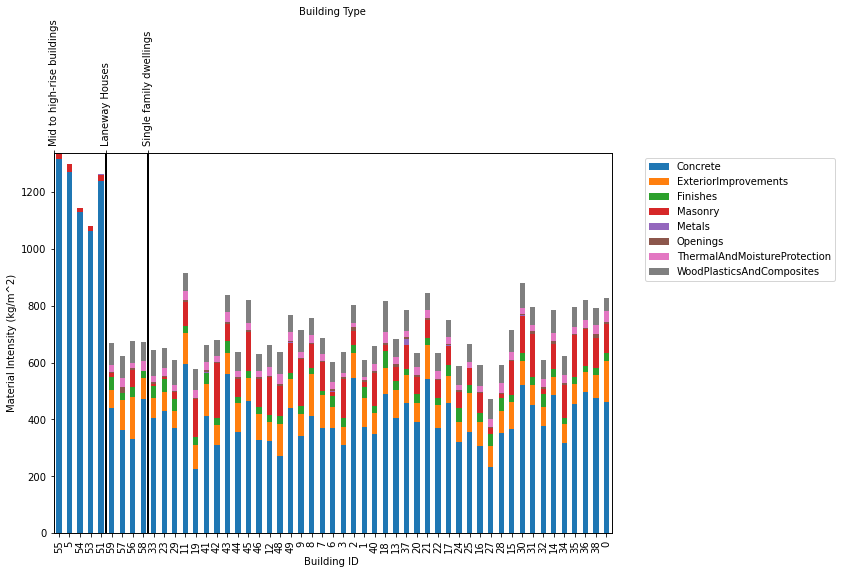

In [36]:
fig, ax = plt.subplots(figsize=(10,7))  

cols = toplot.columns[6:]
margin_bottom = np.zeros(len(toplot))

cmap = plt.get_cmap('tab10')

for num, col in enumerate(cols):
    values = toplot[col].values

    toplot[col].plot.bar(x='Year',y='Value', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=cmap(num), label=col)
    margin_bottom += values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Material Intensity (kg/m^2)')
plt.xlabel('Building ID ')
ax2 = ax.twiny()
ax2.set_xlim(0, len(toplot))
ax2.set_xticks([k for k,v in enumerate(toplot['Building Type'].values) if building_type_map[v] != building_type_map[toplot['Building Type'].values[k-1]] or k==0])
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
ax2.set_xticklabels([building_type_map[v] for k,v in enumerate(toplot['Building Type'].values) if building_type_map[v] != building_type_map[toplot['Building Type'].values[k-1]] or k==0])
ax2.set_xlabel("Building Type")
plt.grid(color='black',linewidth=2)

plt.show()


In [37]:
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)

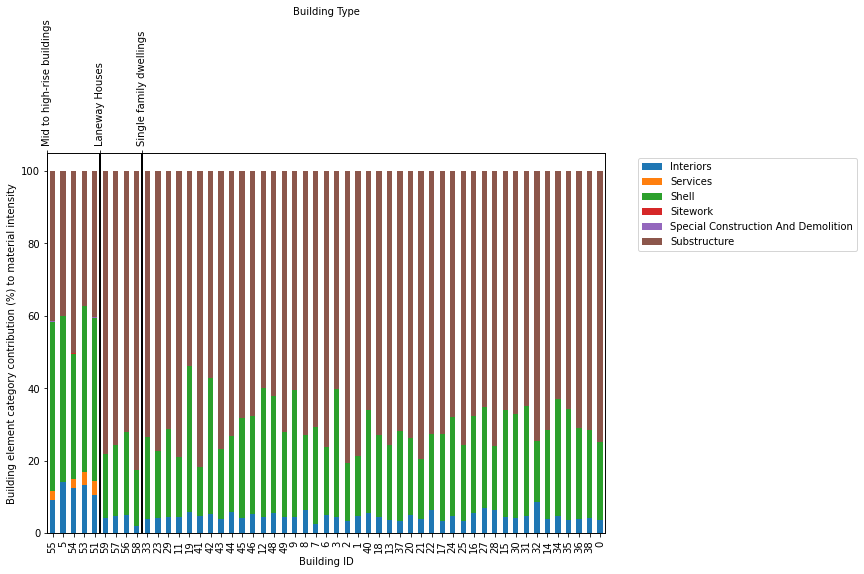

In [38]:
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)
df_mi = df_mi.div(df_mi.sum(axis=1),axis=0) * 100
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0]]
toplot = pd.concat([df[headings[1:]],df_mi[kilogram_columns].groupby(f,axis=1).sum()],axis=1).sort_values('Building Type')
toplot = toplot[toplot['Building Type'].isin(types_to_keep)]

fig, ax = plt.subplots(figsize=(10,7))  

cols = toplot.columns[6:]
margin_bottom = np.zeros(len(toplot))

cmap = plt.get_cmap('tab10')

for num, col in enumerate(cols):
    values = toplot[col].values

    toplot[col].plot.bar(x='Year',y='Value', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=cmap(num), label=col)
    margin_bottom += values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Building ID')
plt.ylabel('Building element category contribution (%) to material intensity')

ax2 = ax.twiny()
ax2.set_xlim(0, len(toplot))
ax2.set_xticks([k for k,v in enumerate(toplot['Building Type'].values) if building_type_map[v] != building_type_map[toplot['Building Type'].values[k-1]] or k==0])
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
ax2.set_xticklabels([building_type_map[v] for k,v in enumerate(toplot['Building Type'].values) if building_type_map[v] != building_type_map[toplot['Building Type'].values[k-1]] or k==0])
ax2.set_xlabel("Building Type")
plt.grid(color='black',linewidth=2)
plt.show()

In [39]:
df_mi = df[kilogram_columns].div(df['Gross Floor Area'],axis=0)
df_mi = df_mi.div(df_mi.sum(axis=1),axis=0)
f = lambda x: name_map[re.split('[_\.\ ]',x)[1][0]] + '/' + re.split('[_\.\ ]',x)[-1]
toplot = df_mi[kilogram_columns].groupby(f,axis=1).sum()
for k,v in toplot.iteritems():
    toplot[k] = v * int(k.split('/')[1])
f = lambda x: x.split('/')[0]
toplot = pd.concat([df['Building Type'],toplot.groupby(f,axis=1).sum()],axis=1).sort_values('Building Type')[['Building Type','Interiors','Shell','Sitework','Substructure']].reset_index()
# toplot['index'] = toplot['index'].astype('str')

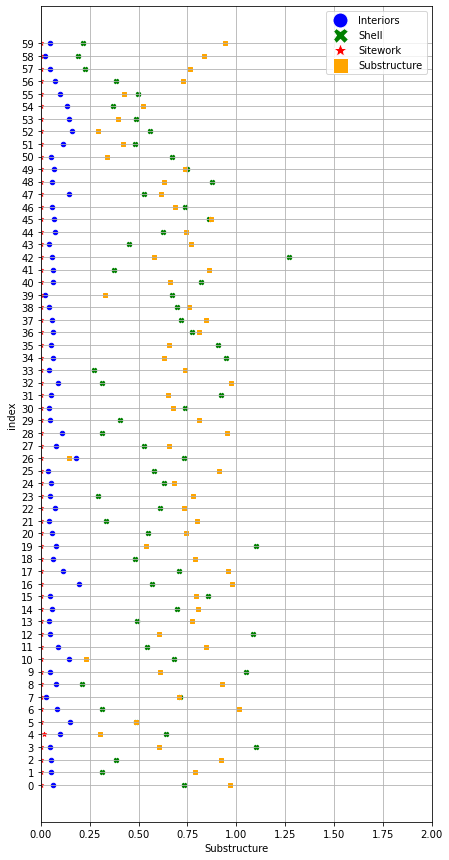

In [40]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(7,15)) 
ax.set_xlim(0,2)
ax.set_yticks(toplot.index)
handles = []
for v,m,c in [('Interiors','o','blue'),('Shell','X','green'),('Sitework','*','red'),('Substructure','s','orange')]:
    toplot.plot.scatter(x=v,y='index', ax=ax, marker=m, color=c)
    handles.append(
        Line2D([0], [0], marker=m, color='w', label=v,
                              markerfacecolor=c, markersize=15)
    )
plt.legend(handles=handles)
plt.grid()